In [1055]:
from urllib.request import urlopen
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import sys
from urllib.parse import urlparse
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

#This will return last modified time of given web page url
def get_last_modified(url):
    result = urlparse(url)
    if True if [result.scheme, result.netloc, result.path] else False:
        header = requests.head(url).headers
        if 'Last-Modified' in header:
            return header['Last-Modified']
        print ("Data is not available")
        return -1
    else:
        return -1

def getNeedNewFile(last_modified):
    text_file = open("lastmodified.txt", "r")
    previous_modified = text_file.read()
    text_file.close()
    if last_modified == previous_modified:
        return False
    else:
        return True

def addLastModified(last_modified):
    text_file = open("lastmodified.txt", "w")
    text_file.write(last_modified)
    text_file.close()

    
def DownloadAndSaveFile(url,filename):
    import urllib.request 
    urllib.request.urlretrieve(url, filename)
    

#2020 population of Catalonia from https://www.idescat.cat/pub/?id=aec&n=245
popCatalunya = 7722203


In [1056]:
#Catalonia's health department data https://dadescovid.cat/descarregues
urldatafile = "https://dadescovid.cat/static/csv/catalunya_diari_total_pob.zip"
urldatafile2 = "https://dadescovid.cat/static/csv/regio_diari_total_pob.zip"
datafile = "data/catalunya_diari_total_pob.zip"
datafile2 = "data/regio_diari_total_pob.zip"

last_modified = get_last_modified(urldatafile)
toget = getNeedNewFile(last_modified)
print("Download new file?", toget)
if toget:
    DownloadAndSaveFile(urldatafile,datafile)
    DownloadAndSaveFile(urldatafile2,datafile2)
    addLastModified(last_modified)
    
df = pd.read_csv(datafile, sep=";")
dfreg = pd.read_csv(datafile2, sep=";")

last_update = max(df["DATA"])
df.head()

Download new file? True


,NOM,CODI,DATA,SEXE,GRUP_EDAT,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,...,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2
0,CATALUNYA,GLOBAL,2021-02-24,Altres,NaN,27,80,21,0,0,...,25,0,8,19,7,2,80,19,14,0
1,CATALUNYA,GLOBAL,2021-02-24,Dona,Entre 15 i 64,252,1494,2262,0,3,...,57,0,24,228,20,180,1325,2154,4585,292
2,CATALUNYA,GLOBAL,2021-02-24,Dona,Entre 65 i 74,27,147,195,1,2,...,50,0,0,27,0,18,140,188,512,9
3,CATALUNYA,GLOBAL,2021-02-24,Dona,Majors de 74,27,246,264,1,0,...,19,1,3,24,3,18,220,242,3644,75
4,CATALUNYA,GLOBAL,2021-02-24,Dona,Menors de 15,32,180,546,0,0,...,0,0,5,27,5,16,170,530,0,0


**Check if new data has been added to the source file**

In [1057]:
previousdf_columns = ['NOM',
 'CODI',
 'DATA',
 'SEXE',
 'GRUP_EDAT',
 'CASOS_CONFIRMAT',
 'PCR',
 'TAR',
 'INGRESSOS_TOTAL',
 'INGRESSOS_CRITIC',
 'INGRESSATS_TOTAL',
 'INGRESSATS_CRITIC',
 'EXITUS',
 'CASOS_PCR',
 'CASOS_TAR',
 'POSITIVITAT_PCR_NUM',
 'POSITIVITAT_TAR_NUM',
 'POSITIVITAT_PCR_DEN',
 'POSITIVITAT_TAR_DEN',
 'VACUNATS_DOSI_1',
 'VACUNATS_DOSI_2']
assert list(df.columns) == previousdf_columns, "Source data has changed format"

In [1058]:
df["DATA"] = pd.to_datetime(df["DATA"])
dfagg = df.groupby("DATA").agg(sum)
dfagg.tail()

,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2
DATA,,,,,,,,,,,,,,,,
2021-02-20,683,10520,3259,87,21,1981,476,32,350,333,360,348,9729,3094,1365,664
2021-02-21,483,5067,2474,79,26,2043,480,36,188,295,168,277,4646,2356,319,21
2021-02-22,1824,24275,12300,144,25,1978,473,22,826,998,889,1014,21831,11691,12114,1556
2021-02-23,1342,25479,9761,116,28,1914,467,15,682,660,816,714,23061,9254,25664,1165
2021-02-24,669,3572,5971,3,11,1824,454,1,80,589,78,451,3214,5719,13728,508


**Date of first vaccination recorded**

In [1059]:
first_vaccination_date=min(dfagg.index[dfagg.VACUNATS_DOSI_1>0])
first_vaccination_date

Timestamp('2020-12-27 00:00:00')

In [1060]:
dfaggvac = dfagg[dfagg.index>=first_vaccination_date]
dfaggvac.reset_index(inplace=True)
dfaggvac['Weekend'] = np.where(dfaggvac["DATA"].dt.weekday < 5,0,1)
dfaggvac["1st dose percent"] = dfaggvac["VACUNATS_DOSI_1"].cumsum()/popCatalunya*100
dfaggvac["2nd dose percent"] = dfaggvac["VACUNATS_DOSI_2"].cumsum()/popCatalunya*100
dfaggvac.head()

,DATA,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2,Weekend,1st dose percent,2nd dose percent
0,2020-12-27,1131,4999,4123,169,33,1788,326,42,404,727,331,574,4620,3898,803,0,1,0.010399,0.0
1,2020-12-28,4029,21879,20009,258,37,1833,339,47,1415,2614,1239,2377,19562,18572,1,0,0,0.010412,0.0
2,2020-12-29,3983,26538,19712,253,26,1850,339,44,1547,2436,1497,2302,23827,18182,447,0,0,0.016200,0.0
3,2020-12-30,3778,27754,19732,233,26,1835,333,47,1500,2278,1532,2233,24750,18484,2585,0,0,0.049675,0.0
4,2020-12-31,3411,22496,17245,238,39,1803,345,48,1447,1964,1627,2009,20154,16198,2592,0,0,0.083240,0.0


In [1061]:
tidy = dfaggvac[["DATA","VACUNATS_DOSI_1","VACUNATS_DOSI_2"]]
tidy.columns = ["DATA","1st","2nd"]
tidy = tidy.melt(id_vars="DATA",ignore_index = False).rename(columns=str.title)
tidy.rename(columns = {'Variable': 'Dose'} , inplace=True)
tidy['Data'] = tidy['Data'].dt.strftime('%d-%b')

In [1062]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
sns.set_style('white')
dmax = max(dfaggvac["DATA"]) + pd.DateOffset(1)
dmin = min(dfaggvac["DATA"]) - pd.DateOffset(1)

Extrapolate from last week number of vaccinations, when will all the Catalan population be vaccinated

In [1063]:
import datetime
lastweek = dfaggvac.tail(7)
vaccperday = np.average(lastweek["VACUNATS_DOSI_2"]) + np.average(lastweek["VACUNATS_DOSI_1"])
nonvaccinated = popCatalunya*(1 -  lastweek.loc[lastweek.index[-1], "2nd dose percent"] /100) + popCatalunya*(1 -  lastweek.loc[lastweek.index[-1], "1st dose percent"] /100)

days_to_end_vaccination = nonvaccinated/vaccperday
vaccination_end = (max(dfaggvac["DATA"]) + datetime.timedelta(days=days_to_end_vaccination)).strftime("%Y-%m-%d")
vaccperday, days_to_end_vaccination, vaccination_end, nonvaccinated, popCatalunya

(13710.42857142857, 1086.4967438758817, '2024-02-15', 14896336.0, 7722203)

<IPython.core.display.Javascript object>


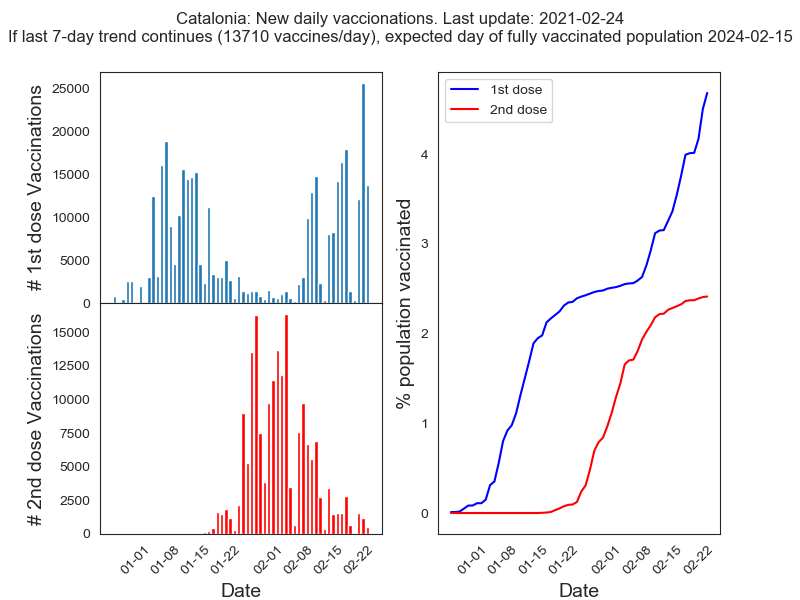

In [1064]:
fig = plt.figure(figsize=(8, 6))

gs = fig.add_gridspec(2,2)

date_form = DateFormatter("%m-%d")
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
fig.suptitle("Catalonia: New daily vaccionations. Last update: " + last_update +
            "\nIf last 7-day trend continues (" + str(int(vaccperday)) +" vaccines/day), expected day of fully vaccinated population " + vaccination_end)

# Defining custom 'xlim' and 'ylim' values.
maxx = max(dfaggvac["VACUNATS_DOSI_1"].max(),dfaggvac["VACUNATS_DOSI_2"].max())
custom_ylim = (0, maxx+1000)

# Setting the values for all axes.
#plt.setp(ax1, ylim=custom_ylim)

ax1 = fig.add_subplot(gs[0, 0])

ax1.bar(x="DATA", height="VACUNATS_DOSI_1",data=dfaggvac)
ax1.set_ylabel("# 1st dose Vaccinations",fontsize=14)
ax1.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

ax2 = fig.add_subplot(gs[1, 0]) 

ax2.bar(x="DATA", height="VACUNATS_DOSI_2",data=dfaggvac, color="red")
ax2.set_xlabel("Date",fontsize=14)
ax2.set_ylabel("# 2nd dose Vaccinations",fontsize=14)
ax2.xaxis.set_major_formatter(date_form)
ax2.tick_params(axis="x",rotation=45)

ax3 = fig.add_subplot(gs[:, 1])

ax3.plot(dfaggvac["DATA"], dfaggvac["1st dose percent"], color="blue", label="1st dose")
ax3.plot(dfaggvac["DATA"], dfaggvac["2nd dose percent"], color="red", label="2nd dose")

ax3.set_xlabel("Date",fontsize=14)
ax3.set_ylabel("% population vaccinated",fontsize=14)
ax3.xaxis.set_major_formatter(date_form)
ax3.legend()
ax3.tick_params(axis="x",rotation=45)

plt.show()
plt.savefig('CurrentOverallVaccinationCat.png')

<IPython.core.display.Javascript object>


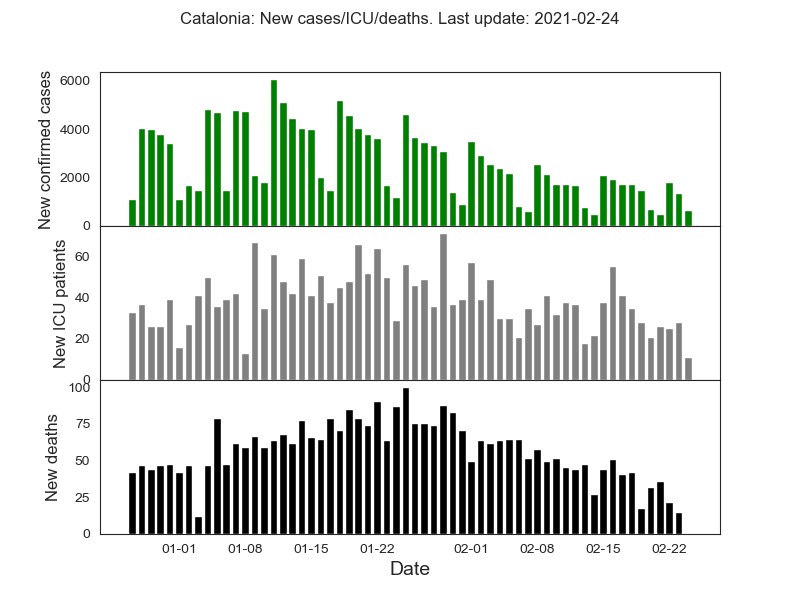

In [1065]:
fig3, ax3 = plt.subplots(3,1,figsize=(8, 6), sharex=True)
date_form = DateFormatter("%m-%d")
# Remove horizontal space between axes
fig3.subplots_adjust(hspace=0)
fig3.suptitle("Catalonia: New cases/ICU/deaths. Last update: " + last_update)

ax3[0].bar(x="DATA", height="CASOS_CONFIRMAT",data=dfaggvac, color="green")
ax3[0].set_ylabel("New confirmed cases",fontsize=12)

ax3[1].bar(x="DATA", height="INGRESSOS_CRITIC",data=dfaggvac, color="grey")
ax3[1].set_ylabel("New ICU patients",fontsize=12)

ax3[2].bar(x="DATA", height="EXITUS",data=dfaggvac, color="black")
ax3[2].set_xlabel("Date",fontsize=14)
ax3[2].set_ylabel("New deaths",fontsize=12)
ax3[2].xaxis.set_major_formatter(date_form)

plt.show()
plt.savefig('CurrentCasesICUDeathsCat.png')

In [1066]:
dfage = df.groupby(["DATA","GRUP_EDAT"]).agg(sum)
dfage.head()
#Població per sexe i grups d'edat: https://www.idescat.cat/pub/?id=aec&n=253


CASOS_CONFIRMAT  PCR  TAR  INGRESSOS_TOTAL  \
DATA       GRUP_EDAT                                                   
2020-03-01 Entre 15 i 64                1   12    0                0   
           Entre 65 i 74                0    4    0                0   
           Majors de 74                 0    4    0                0   
           Menors de 15                 0    0    0                0   
2020-03-02 Entre 15 i 64                4   25    0                0   

                          INGRESSOS_CRITIC  INGRESSATS_TOTAL  \
DATA       GRUP_EDAT                                           
2020-03-01 Entre 15 i 64                 0                 0   
           Entre 65 i 74                 0                 0   
           Majors de 74                  0                 0   
           Menors de 15                  0                 0   
2020-03-02 Entre 15 i 64                 0                 0   

                          INGRESSATS_CRITIC  EXITUS  CASOS_PCR  CASOS_TAR  \
DATA       GRUP_EDAT                                                        
2020-03-01 Entre 15 i 64                  0       0          1          0   
           Entre 65 i 74                  0       0          0          0   
           Majors de 74                   0       0          0          0   
           Menors de 15                   0       0          0          0   
2020-03-02 Entre 15 i 64                  0       0          4          0   

                          POSITIVITAT_PCR_NUM  POSITIVITAT_TAR_NUM  \
DATA       GRUP_EDAT                                                 
2020-03-01 Entre 15 i 64                    0                    0   
           Entre 65 i 74                    0                    0   
           Majors de 74                     0                    0   
           Menors de 15                     0                    0   
2020-03-02 Entre 15 i 64                    2                    0   

                          POSITIVITAT_PCR_DEN  POSITIVITAT_TAR_DEN  \
DATA       GRUP_EDAT                                                 
2020-03-01 Entre 15 i 64                   12                    0   
           Entre 65 i 74                    4                    0   
           Majors de 74                     4                    0   
           Menors de 15                     0                    0   
2020-03-02 Entre 15 i 64                   25                    0   

                          VACUNATS_DOSI_1  VACUNATS_DOSI_2  
DATA       GRUP_EDAT                                        
2020-03-01 Entre 15 i 64                0                0  
           Entre 65 i 74                0                0  
           Majors de 74                 0                0  
           Menors de 15                 0                0  
2020-03-02 Entre 15 i 64                0                0

In [1067]:
#Downloaded from https://www.idescat.cat/pub/?id=aec&n=253
popdf = pd.read_html("data/aec-253.xls")
popdf = popdf[0]
popdf = popdf[:-4]
popdf = popdf[["Unnamed: 0", "Homes", "Dones", "Total"]]
popdf.rename(columns={"Unnamed: 0":"Age range", "Homes" : "Men", "Dones":"Women"},inplace=True)
popdf.replace({'\.':''}, regex=True,inplace=True)
popdf = popdf.astype({'Men': 'int64','Women': 'int64','Total': 'int64'})
popdf

,Age range,Men,Women,Total
0,De 0 a 4 anys,177639,168224,345863
1,De 5 a 9 anys,207060,194449,401509
2,De 10 a 14 anys,223267,208376,431643
3,De 15 a 19 anys,210527,193260,403787
4,De 20 a 24 anys,205008,191087,396095
5,De 25 a 29 anys,221110,216044,437154
6,De 30 a 34 anys,231001,235104,466105
7,De 35 a 39 anys,270896,274488,545384
8,De 40 a 44 anys,334557,325651,660208
9,De 45 a 49 anys,324031,313261,637292


In [1068]:
popranges = np.sum(popdf.loc[0:3,"Total"]), np.sum(popdf.loc[3:13,"Total"]), np.sum(popdf.loc[13:15,"Total"]),np.sum(popdf.loc[15:,"Total"])
popranges = pd.Series(popranges,index=['Menors de 15','Entre 15 i 64', 'Entre 65 i 74', 'Majors de 74'])
popranges

Menors de 15     1582802
Entre 15 i 64    5462530
Entre 65 i 74    1016572
Majors de 74      725118
dtype: int64

In [1069]:
dfage.reset_index(inplace=True)
dfage

,DATA,GRUP_EDAT,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2
0,2020-03-01,Entre 15 i 64,1,12,0,0,0,0,0,0,1,0,0,0,12,0,0,0
1,2020-03-01,Entre 65 i 74,0,4,0,0,0,0,0,0,0,0,0,0,4,0,0,0
2,2020-03-01,Majors de 74,0,4,0,0,0,0,0,0,0,0,0,0,4,0,0,0
3,2020-03-01,Menors de 15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2020-03-02,Entre 15 i 64,4,25,0,0,0,0,0,0,4,0,2,0,25,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2021-02-23,Menors de 15,221,4386,2083,0,0,5,0,0,145,76,167,86,4193,2009,2,0
1440,2021-02-24,Entre 15 i 64,491,2334,3992,1,6,623,199,0,49,442,47,362,2083,3815,6948,379
1441,2021-02-24,Entre 65 i 74,45,323,355,1,4,445,158,0,4,41,4,25,298,344,890,18
1442,2021-02-24,Majors de 74,45,476,469,1,1,631,72,1,5,40,5,33,420,438,5876,111


In [1070]:
dfage = dfage[dfage.DATA>=first_vaccination_date]
aggAgedf = []
for x in popranges.index:
    x1 = dfage[dfage.GRUP_EDAT==x]
    x1["1st dose percent"] =  x1["VACUNATS_DOSI_1"].cumsum()/popranges[x]*100
    x1["2nd dose percent"] =  x1["VACUNATS_DOSI_2"].cumsum()/popranges[x]*100
    
    aggAgedf.append(x1)

<IPython.core.display.Javascript object>


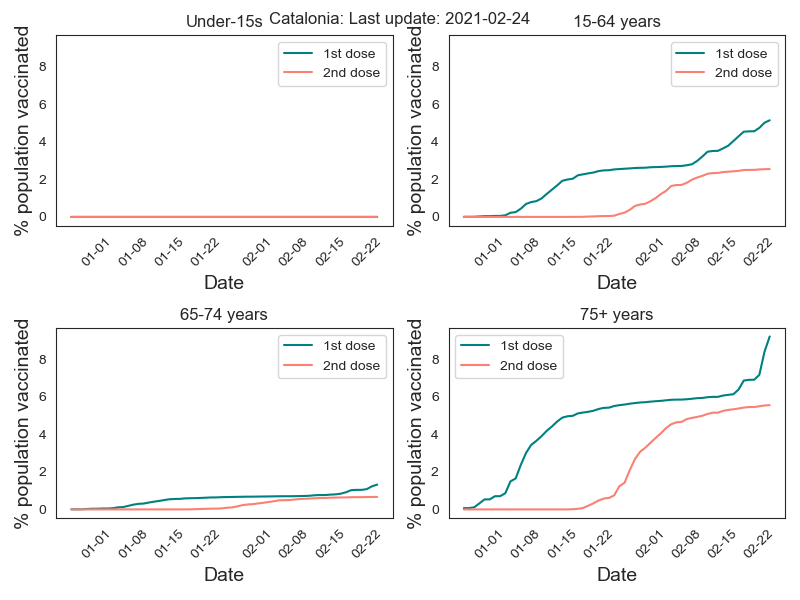

In [1071]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle("Catalonia: Last update: " + last_update)

gs = fig.add_gridspec(2,2)


ax = fig.add_subplot(gs[0, 0])
ax.plot(aggAgedf[0]["DATA"], aggAgedf[0]["1st dose percent"], color="teal", label="1st dose")
ax.plot(aggAgedf[0]["DATA"], aggAgedf[0]["2nd dose percent"], color="salmon", label="2nd dose")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("% population vaccinated",fontsize=14)
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)
ax.title.set_text("Under-15s")


ax = fig.add_subplot(gs[0, 1], sharey=ax)
ax.plot(aggAgedf[1]["DATA"], aggAgedf[1]["1st dose percent"], color="teal", label="1st dose")
ax.plot(aggAgedf[1]["DATA"], aggAgedf[1]["2nd dose percent"], color="salmon", label="2nd dose")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("% population vaccinated",fontsize=14)
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)
ax.title.set_text("15-64 years")


ax = fig.add_subplot(gs[1, 0], sharey=ax)
ax.plot(aggAgedf[2]["DATA"], aggAgedf[2]["1st dose percent"], color="teal", label="1st dose")
ax.plot(aggAgedf[2]["DATA"], aggAgedf[2]["2nd dose percent"], color="salmon", label="2nd dose")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("% population vaccinated",fontsize=14)
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)
ax.title.set_text("65-74 years")


ax = fig.add_subplot(gs[1, 1], sharey=ax)
ax.plot(aggAgedf[3]["DATA"], aggAgedf[3]["1st dose percent"], color="teal", label="1st dose")
ax.plot(aggAgedf[3]["DATA"], aggAgedf[3]["2nd dose percent"], color="salmon", label="2nd dose")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("% population vaccinated",fontsize=14)
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)
ax.title.set_text("75+ years")
gs.tight_layout(fig)

plt.show()
plt.savefig('CurrentByAgeVaccinationCat.png')

**Data by region**

In [1072]:
#https://dadescovid.cat/static/csv/regio_diari_total_pob.zip
#Catalonia's health department data https://dadescovid.cat/descarregues

dfreg.head()

,NOM,CODI,DATA,SEXE,GRUP_EDAT,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,...,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2
0,ALT PIRINEU I ARAN,71,2021-02-24,Dona,Entre 15 i 64,5,10,39,0,0,...,0,0,1,4,0,4,10,33,58,1
1,ALT PIRINEU I ARAN,71,2021-02-24,Dona,Entre 65 i 74,0,0,0,0,0,...,1,0,0,0,0,0,0,0,9,0
2,ALT PIRINEU I ARAN,71,2021-02-24,Dona,Majors de 74,0,3,0,0,0,...,0,0,0,0,0,0,2,0,43,0
3,ALT PIRINEU I ARAN,71,2021-02-24,Dona,Menors de 15,1,1,6,0,0,...,0,0,0,1,0,0,1,6,0,0
4,ALT PIRINEU I ARAN,71,2021-02-24,Home,Entre 15 i 64,1,5,8,0,0,...,1,0,1,0,1,0,4,8,28,0


In [1073]:
regions = dfreg["NOM"].unique()
dfreg["DATA"] = pd.to_datetime(dfreg["DATA"])
dfreg = dfreg[dfreg.DATA>=first_vaccination_date]
dfregagg = dfreg.groupby(["NOM","DATA"]).agg(sum)
dfregagg.head()

CODI  CASOS_CONFIRMAT  PCR  TAR  \
NOM                DATA                                          
ALT PIRINEU I ARAN 2020-12-27   568               15   52   31   
                   2020-12-28   568               39  285  163   
                   2020-12-29   568               59  218  195   
                   2020-12-30   568               45  141  260   
                   2020-12-31   568               78  360  192   

                               INGRESSOS_TOTAL  INGRESSOS_CRITIC  \
NOM                DATA                                            
ALT PIRINEU I ARAN 2020-12-27                3                 1   
                   2020-12-28                7                 2   
                   2020-12-29                0                 0   
                   2020-12-30                3                 0   
                   2020-12-31                4                 1   

                               INGRESSATS_TOTAL  INGRESSATS_CRITIC  EXITUS  \
NOM                DATA                                                      
ALT PIRINEU I ARAN 2020-12-27                18                  5       0   
                   2020-12-28                22                  7       0   
                   2020-12-29                23                  7       0   
                   2020-12-30                24                  7       0   
                   2020-12-31                23                  6       1   

                               CASOS_PCR  CASOS_TAR  POSITIVITAT_PCR_NUM  \
NOM                DATA                                                    
ALT PIRINEU I ARAN 2020-12-27          6          9                    5   
                   2020-12-28         19         20                   18   
                   2020-12-29         15         44                   16   
                   2020-12-30         14         31                   12   
                   2020-12-31         28         50                   38   

                               POSITIVITAT_TAR_NUM  POSITIVITAT_PCR_DEN  \
NOM                DATA                                                   
ALT PIRINEU I ARAN 2020-12-27                    8                   43   
                   2020-12-28                   14                  243   
                   2020-12-29                   44                  172   
                   2020-12-30                   30                  124   
                   2020-12-31                   46                  324   

                               POSITIVITAT_TAR_DEN  VACUNATS_DOSI_1  \
NOM                DATA                                               
ALT PIRINEU I ARAN 2020-12-27                   27               80   
                   2020-12-28                  159                0   
                   2020-12-29                  185               48   
                   2020-12-30                  243               93   
                   2020-12-31                  189              107   

                               VACUNATS_DOSI_2  
NOM                DATA                         
ALT PIRINEU I ARAN 2020-12-27                0  
                   2020-12-28                0  
                   2020-12-29                0  
                   2020-12-30                0  
                   2020-12-31                0

In [1074]:
regions

array(['ALT PIRINEU I ARAN', 'BARCELONA CIUTAT', 'CAMP DE TARRAGONA',
       'CATALUNYA CENTRAL', 'GIRONA', 'LLEIDA', 'METROPOLITANA NORD',
       'METROPOLITANA SUD', "TERRES DE L'EBRE"], dtype=object)

#Population data from https://catsalut.gencat.cat/web/.content/minisite/catsalut/proveidors_professionals/registres_catalegs/documents/poblacio-referencia.pdf

**Regions sanitàries Població**

Alt Pirineu i Aran 67.277

Lleida 362.850

Camp de Tarragona 607.999

Terres de l'Ebre 176.817

Girona 861.753

Catalunya Central 526.959

Barcelona 5.050.190

    Àmbit Territorial Barcelona Ciutat 1.693.449
    Àmbit Territorial Metropolità Nord 1.986.032
    Àmbit Territorial Metropolità Sud 1.370.709

Total Catalunya 7.653.845

In [1075]:
popregions = pd.Series([67277, 1693449,607999,526959,861753,362850,1986032,1370709,176817],index=regions)
popregions

ALT PIRINEU I ARAN      67277
BARCELONA CIUTAT      1693449
CAMP DE TARRAGONA      607999
CATALUNYA CENTRAL      526959
GIRONA                 861753
LLEIDA                 362850
METROPOLITANA NORD    1986032
METROPOLITANA SUD     1370709
TERRES DE L'EBRE       176817
dtype: int64

In [1076]:
dfregagg.reset_index(inplace=True)
dfregagg.set_index("NOM",inplace=True)
dfregagg

,DATA,CODI,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2
NOM,,,,,,,,,,,,,,,,,,
ALT PIRINEU I ARAN,2020-12-27,568,15,52,31,3,1,18,5,0,6,9,5,8,43,27,80,0
ALT PIRINEU I ARAN,2020-12-28,568,39,285,163,7,2,22,7,0,19,20,18,14,243,159,0,0
ALT PIRINEU I ARAN,2020-12-29,568,59,218,195,0,0,23,7,0,15,44,16,44,172,185,48,0
ALT PIRINEU I ARAN,2020-12-30,568,45,141,260,3,0,24,7,0,14,31,12,30,124,243,93,0
ALT PIRINEU I ARAN,2020-12-31,568,78,360,192,4,1,23,6,1,28,50,38,46,324,189,107,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TERRES DE L'EBRE,2021-02-20,504,4,71,55,1,0,42,17,0,2,2,2,3,64,55,11,1
TERRES DE L'EBRE,2021-02-21,504,2,35,53,2,0,44,16,0,1,1,1,1,32,51,1,0
TERRES DE L'EBRE,2021-02-22,504,16,372,213,2,0,40,15,0,2,14,4,15,349,207,177,67


In [1077]:
dfregagg['Weekend'] = np.where(dfregagg["DATA"].dt.weekday < 5,0,1)
dfregagg['1st dose percent'] = dfregagg.groupby("NOM")['VACUNATS_DOSI_1'].transform(pd.Series.cumsum)
dfregagg['2nd dose percent'] = dfregagg.groupby("NOM")['VACUNATS_DOSI_2'].transform(pd.Series.cumsum)


#dfregagg["1st dose percent"] = dfregagg["VACUNATS_DOSI_1"].cumsum()/popCatalunya*100
#dfregagg["2nd dose percent"] = dfregagg["VACUNATS_DOSI_2"].cumsum()/popCatalunya*100
dfregagg['1st dose percent'] = dfregagg['1st dose percent']*100/popregions[dfregagg.index]
dfregagg['2nd dose percent'] = dfregagg['2nd dose percent']*100/popregions[dfregagg.index]

In [1078]:
dfregagg.tail()

,DATA,CODI,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,...,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2,Weekend,1st dose percent,2nd dose percent
NOM,,,,,,,,,,,,,,,,,,,,,
TERRES DE L'EBRE,2021-02-20,504,4,71,55,1,0,42,17,0,...,2,2,3,64,55,11,1,1,4.207175,2.454515
TERRES DE L'EBRE,2021-02-21,504,2,35,53,2,0,44,16,0,...,1,1,1,32,51,1,0,1,4.207740,2.454515
TERRES DE L'EBRE,2021-02-22,504,16,372,213,2,0,40,15,0,...,14,4,15,349,207,177,67,0,4.307844,2.492407
TERRES DE L'EBRE,2021-02-23,504,4,398,147,2,1,39,16,0,...,3,2,5,368,141,1202,12,0,4.987643,2.499194
TERRES DE L'EBRE,2021-02-24,504,5,39,106,0,0,38,14,0,...,5,0,5,35,103,613,28,0,5.334329,2.515030


<IPython.core.display.Javascript object>


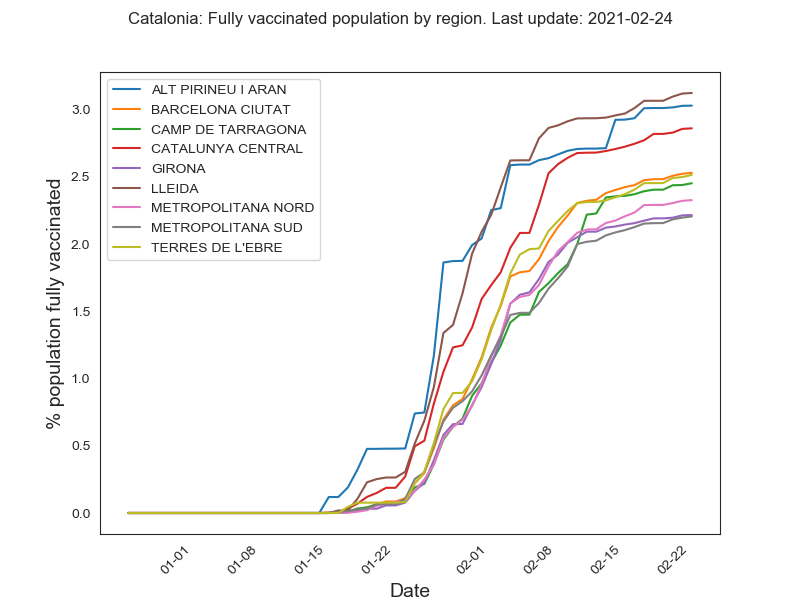

In [1079]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle("Catalonia: Fully vaccinated population by region. Last update: " + last_update)
ax = sns.lineplot(x="DATA",y="2nd dose percent",data=dfregagg,hue="NOM",)
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("% population fully vaccinated",fontsize=14)
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)
plt.savefig('CurrentRegionVaccinationCat.png')

**Fully vaccinated vs people in hospitalized and ICU patients currently in hospital**

In [1080]:
dfaggvac.head()

,DATA,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2,Weekend,1st dose percent,2nd dose percent
0,2020-12-27,1131,4999,4123,169,33,1788,326,42,404,727,331,574,4620,3898,803,0,1,0.010399,0.0
1,2020-12-28,4029,21879,20009,258,37,1833,339,47,1415,2614,1239,2377,19562,18572,1,0,0,0.010412,0.0
2,2020-12-29,3983,26538,19712,253,26,1850,339,44,1547,2436,1497,2302,23827,18182,447,0,0,0.016200,0.0
3,2020-12-30,3778,27754,19732,233,26,1835,333,47,1500,2278,1532,2233,24750,18484,2585,0,0,0.049675,0.0
4,2020-12-31,3411,22496,17245,238,39,1803,345,48,1447,1964,1627,2009,20154,16198,2592,0,0,0.083240,0.0


<IPython.core.display.Javascript object>


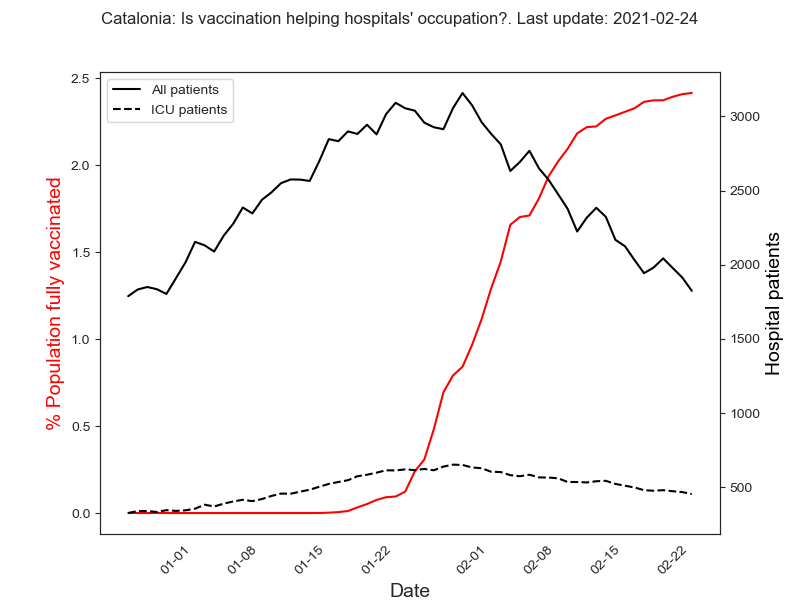

In [1081]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(8, 6))
fig.suptitle("Catalonia: Is vaccination helping hospitals' occupation?. Last update: " + last_update)

# make a plot
ax.plot(dfaggvac["DATA"], dfaggvac["2nd dose percent"], color="red", label="Fully vaccinated rate")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("% Population fully vaccinated",color="red",fontsize=14)
ax.xaxis.set_major_formatter(DateFormatter("%m-%d"))
ax.tick_params(axis="x",rotation=45)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(dfaggvac["DATA"], dfaggvac["INGRESSATS_TOTAL"], color="black", label="All patients")
ax2.plot(dfaggvac["DATA"], dfaggvac["INGRESSATS_CRITIC"], '--', color="black", label="ICU patients")

ax2.set_ylabel("Hospital patients",color="black",fontsize=14)
ax2.xaxis.set_major_formatter(DateFormatter("%m-%d"))

ax2.legend(loc='upper left')
plt.show()
plt.savefig('HospitalVSVaccinationCat.png')

In [1082]:
dflast

,NOMRS,DATA,CODI,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,...,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2,Weekend,1st dose percent,2nd dose percent
0,ALT PIRINEU I ARAN,2021-02-23,568.0,7.0,25.0,63.0,0.0,0.0,21.0,3.0,...,7.0,0.0,4.0,22.0,61.0,64.0,0.0,0.0,4.716322,3.014403
1,CAMP DE TARRAGONA,2021-02-23,496.0,36.0,181.0,394.0,0.0,0.0,116.0,41.0,...,34.0,9.0,33.0,163.0,385.0,512.0,5.0,0.0,4.282902,2.437504
2,CATALUNYA CENTRAL,2021-02-23,536.0,45.0,210.0,315.0,0.0,1.0,147.0,30.0,...,38.0,8.0,29.0,184.0,287.0,443.0,6.0,0.0,4.229931,2.829442
3,GIRONA,2021-02-23,512.0,88.0,202.0,685.0,0.0,2.0,219.0,44.0,...,84.0,3.0,77.0,176.0,652.0,1057.0,48.0,0.0,3.911794,2.184153
4,LLEIDA,2021-02-23,488.0,20.0,61.0,247.0,0.0,0.0,82.0,27.0,...,18.0,2.0,15.0,53.0,234.0,289.0,2.0,0.0,5.232741,3.093289
5,TERRES DE L'EBRE,2021-02-23,504.0,5.0,72.0,90.0,0.0,0.0,40.0,16.0,...,4.0,1.0,5.0,65.0,85.0,534.0,2.0,0.0,4.609851,2.492407
6,BARCELONA,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.345575


In [1083]:
dflast = dfregagg[dfregagg.DATA==last_update]

a=(dflast.loc["BARCELONA CIUTAT"]["2nd dose percent"]*popregions["BARCELONA CIUTAT"] 
+ dflast.loc["METROPOLITANA NORD"]["2nd dose percent"]*popregions["METROPOLITANA NORD"]
+ dflast.loc["METROPOLITANA SUD"]["2nd dose percent"]*popregions["METROPOLITANA SUD"])

b=(popregions["BARCELONA CIUTAT"]+popregions["METROPOLITANA NORD"]+popregions["METROPOLITANA SUD"])
dfaux = pd.DataFrame({'2nd dose percent':a/b},index=["BARCELONA"])
dflast = dflast.append(dfaux)
dflast = dflast.drop(["BARCELONA CIUTAT", "METROPOLITANA NORD", "METROPOLITANA SUD"])
dflast.reset_index(inplace=True)
dflast.rename(columns={"index":"NOMRS"}, inplace=True)
dflast.head()

,NOMRS,DATA,CODI,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,...,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2,Weekend,1st dose percent,2nd dose percent
0,ALT PIRINEU I ARAN,2021-02-24,568.0,7.0,28.0,59.0,0.0,0.0,23.0,3.0,...,5.0,1.0,4.0,25.0,53.0,171.0,1.0,0.0,5.104270,3.030753
1,CAMP DE TARRAGONA,2021-02-24,496.0,28.0,315.0,376.0,3.0,1.0,113.0,37.0,...,24.0,4.0,24.0,288.0,370.0,651.0,80.0,0.0,4.541290,2.453294
2,CATALUNYA CENTRAL,2021-02-24,536.0,51.0,258.0,297.0,0.0,0.0,141.0,29.0,...,42.0,9.0,33.0,218.0,280.0,880.0,22.0,0.0,4.597511,2.861892
3,GIRONA,2021-02-24,512.0,102.0,263.0,775.0,0.0,0.0,202.0,40.0,...,96.0,6.0,76.0,233.0,742.0,1733.0,20.0,0.0,4.456149,2.216528
4,LLEIDA,2021-02-24,488.0,30.0,104.0,215.0,0.0,0.0,79.0,27.0,...,28.0,2.0,19.0,89.0,208.0,1240.0,15.0,0.0,5.754995,3.124707


In [1084]:
import geopandas as gpd
dfmap=gpd.read_file("shapefile/ABS_2018/RegionsS_2018.shp")
dfmap["NOMRS"] = dfmap["NOMRS"].str.replace("Regió Sanitària ", '').str.upper()

In [1085]:
dfmap = dfmap.merge(dflast[["NOMRS","2nd dose percent"]])
dfmap.head()

,CODIRS,NOMRS,ÀREA,geometry,2nd dose percent
0,62,CAMP DE TARRAGONA,2.755252e+09,"MULTIPOLYGON (((323341.750 4538212.510, 323344...",2.453294
1,64,GIRONA,5.765363e+09,"MULTIPOLYGON (((470266.440 4606110.290, 470267...",2.216528
2,78,BARCELONA,2.954231e+09,"MULTIPOLYGON (((395337.879 4563748.012, 395336...",2.362842
3,67,CATALUNYA CENTRAL,6.067787e+09,"POLYGON ((359427.518 4594965.930, 359390.449 4...",2.861892
4,63,TERRES DE L'EBRE,3.355167e+09,"MULTIPOLYGON (((293729.790 4495731.740, 293731...",2.515030


<IPython.core.display.Javascript object>


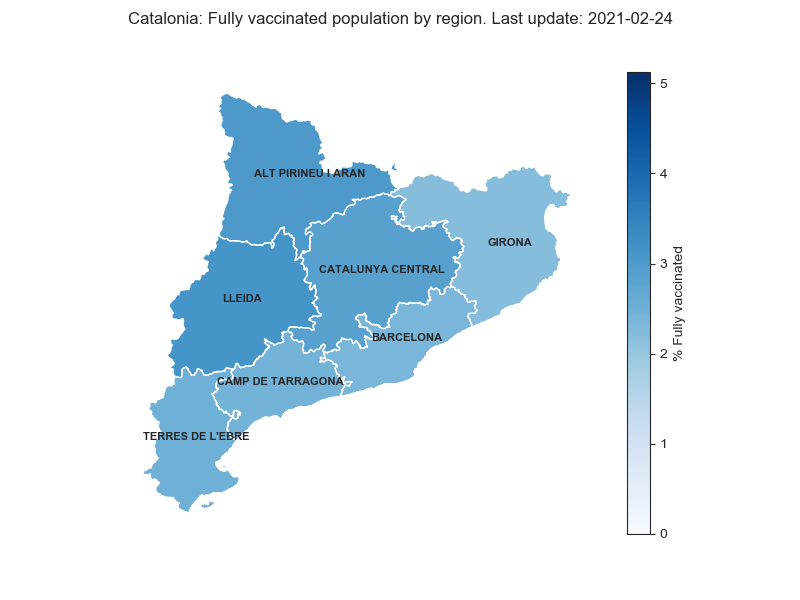

In [1086]:
fig, ax = plt.subplots(figsize = (8,6))
fig.suptitle("Catalonia: Fully vaccinated population by region. Last update: " + last_update)
ax.axis("off")
dfmap.plot(ax=ax,column='2nd dose percent',  legend=True,cmap='Blues',  
           legend_kwds={'label': '% Fully vaccinated'},vmin=0,vmax=min(100,2+max(dfmap["2nd dose percent"])))


dfmap['coords'] = dfmap['geometry'].apply(lambda x: x.representative_point().coords[:])
dfmap['coords'] = [coords[0] for coords in dfmap['coords']]

for idx, row in dfmap.iterrows():
    plt.annotate(s=row['NOMRS'], xy=row['coords'],
                 horizontalalignment='center', fontsize = 8,fontweight='bold')

plt.savefig('MapCurrentRegionVaccinationCat.png')

***Vacunació per al COVID-19 per àrea bàsica de salut***

https://analisi.transparenciacatalunya.cat/Salut/Vacunaci-per-al-COVID-19-per-rea-b-sica-de-salut/tp23-dey4

Aquestes dades provenen de diversos sistemes d'informació del Departament de Salut i del Servei Català de la Salut, detallats a https://dadescovid.cat/documentacio , i mostren per a cada dia, àrea bàsica de salut, sexe i grup d'edat, el nombre de dosis administrades de vacunes per al SARS-CoV-2, amb el detall del producte administrat i del número de dosi, i també el nombre de persones citades en la data de referència per a ser vacunades i per a les quals se n'ha descartat la vacunació, per algun d'aquests motius: per rebuig del pacient, per estar contraindicada la immunització o bé perquè el pacient ha passat la malaltia.

En els casos en què no ha estat possible identificar l'àrea bàsica de salut de residència de la persona a qui s'ha administrat la dosi, o de qui se n'ha descartat la vacunació, el valor de la variable 'ABS' és 'No classificat'.

In [1087]:
urldatafile3 = "https://analisi.transparenciacatalunya.cat/api/views/tp23-dey4/rows.csv?accessType=DOWNLOAD&bom=true&format=true&delimiter=%3B&sorting=true"
datafile3 = "data/Vacunaci__per_al_COVID-19_per__rea_b_sica_de_salut.csv"
if toget:
    DownloadAndSaveFile(urldatafile3,datafile3)
casesdf = pd.read_csv(datafile3, sep=";")
casesdf.head()

,SEXE_CODI,SEXE,REGIO_CODI,REGIO,SECTOR_CODI,SECTOR,AGA_CODI,AGA,ABS_CODI,ABS,EDAT,DOSI,DATA,FABRICANT,NO_VACUNAT,RECOMPTE
0,1.0,Dona,6700.0,CATALUNYA CENTRAL,6763.0,SOLSONÈS-BAGES-BERGUEDÀ,59.0,Bages i Solsonès,146.0,MANRESA 2,15 a 64,2,26/01/2021,BioNTech / Pfizer,NaN,39
1,1.0,Dona,6100.0,LLEIDA,6156.0,LLEIDA,5.0,Lleida,138.0,LLEIDA 4,15 a 64,1,15/01/2021,BioNTech / Pfizer,NaN,52
2,1.0,Dona,7803.0,BARCELONA CIUTAT,7850.0,BARCELONA SARRIÀ-SANT GERVASI,47.0,Barcelona Nord,46.0,BARCELONA 5-E,15 a 64,1,13/01/2021,BioNTech / Pfizer,NaN,61
3,1.0,Dona,7802.0,METROPOLITANA NORD,7844.0,VALLÈS OCCIDENTAL EST,35.0,Vallès Occidental Est,105.0,CERDANYOLA DEL VALLÈS 2,15 a 64,2,19/02/2021,Moderna / Lonza,NaN,1
4,0.0,Home,7802.0,METROPOLITANA NORD,7844.0,VALLÈS OCCIDENTAL EST,35.0,Vallès Occidental Est,190.0,SABADELL 1A,65 a 74,1,07/01/2021,BioNTech / Pfizer,NaN,7


In [1088]:
casesdf.loc[casesdf['NO_VACUNAT'] == "No vacunat", 'VACUNAT'] = 0
casesdf.loc[casesdf['NO_VACUNAT'].isna(), 'VACUNAT'] = 1

In [1089]:
casesdf.head()

,SEXE_CODI,SEXE,REGIO_CODI,REGIO,SECTOR_CODI,SECTOR,AGA_CODI,AGA,ABS_CODI,ABS,EDAT,DOSI,DATA,FABRICANT,NO_VACUNAT,RECOMPTE,VACUNAT
0,1.0,Dona,6700.0,CATALUNYA CENTRAL,6763.0,SOLSONÈS-BAGES-BERGUEDÀ,59.0,Bages i Solsonès,146.0,MANRESA 2,15 a 64,2,26/01/2021,BioNTech / Pfizer,NaN,39,1.0
1,1.0,Dona,6100.0,LLEIDA,6156.0,LLEIDA,5.0,Lleida,138.0,LLEIDA 4,15 a 64,1,15/01/2021,BioNTech / Pfizer,NaN,52,1.0
2,1.0,Dona,7803.0,BARCELONA CIUTAT,7850.0,BARCELONA SARRIÀ-SANT GERVASI,47.0,Barcelona Nord,46.0,BARCELONA 5-E,15 a 64,1,13/01/2021,BioNTech / Pfizer,NaN,61,1.0
3,1.0,Dona,7802.0,METROPOLITANA NORD,7844.0,VALLÈS OCCIDENTAL EST,35.0,Vallès Occidental Est,105.0,CERDANYOLA DEL VALLÈS 2,15 a 64,2,19/02/2021,Moderna / Lonza,NaN,1,1.0
4,0.0,Home,7802.0,METROPOLITANA NORD,7844.0,VALLÈS OCCIDENTAL EST,35.0,Vallès Occidental Est,190.0,SABADELL 1A,65 a 74,1,07/01/2021,BioNTech / Pfizer,NaN,7,1.0


In [1090]:
vacc_ratio = casesdf.groupby(["REGIO","VACUNAT"])["VACUNAT"].count().unstack()

vacc_ratio.loc["BARCELONA"] = vacc_ratio.loc["BARCELONA CIUTAT"] + vacc_ratio.loc["METROPOLITANA NORD"] + vacc_ratio.loc["METROPOLITANA SUD"]
vacc_ratio = vacc_ratio.drop(["BARCELONA CIUTAT","METROPOLITANA NORD","METROPOLITANA SUD","No classificat"])
vacc_ratio.reset_index(inplace=True)
vacc_ratio.rename(columns={"REGIO":"NOMRS"}, inplace=True)
vacc_ratio

VACUNAT,NOMRS,0.0,1.0
0,ALT PIRINEU I ARAN,56,723
1,CAMP DE TARRAGONA,393,5713
2,CATALUNYA CENTRAL,351,5711
3,GIRONA,727,6700
4,LLEIDA,421,3810
5,TERRES DE L'EBRE,84,1862
6,BARCELONA,3016,50145


In [1091]:
vacc_ratio["rejection_rate"]= 100*vacc_ratio[0]/(vacc_ratio[0]+vacc_ratio[1])
vacc_ratio

VACUNAT,NOMRS,0.0,1.0,rejection_rate
0,ALT PIRINEU I ARAN,56,723,7.188703
1,CAMP DE TARRAGONA,393,5713,6.436292
2,CATALUNYA CENTRAL,351,5711,5.790168
3,GIRONA,727,6700,9.788609
4,LLEIDA,421,3810,9.950366
5,TERRES DE L'EBRE,84,1862,4.316547
6,BARCELONA,3016,50145,5.673332


In [1092]:
dfmap = dfmap.merge(vacc_ratio[["NOMRS","rejection_rate"]])
dfmap.head()

,CODIRS,NOMRS,ÀREA,geometry,2nd dose percent,coords,rejection_rate
0,62,CAMP DE TARRAGONA,2.755252e+09,"MULTIPOLYGON (((323341.750 4538212.510, 323344...",2.453294,"(345953.79191678984, 4567495.93335)",6.436292
1,64,GIRONA,5.765363e+09,"MULTIPOLYGON (((470266.440 4606110.290, 470267...",2.216528,"(487628.46966149815, 4653402.25)",9.788609
2,78,BARCELONA,2.954231e+09,"MULTIPOLYGON (((395337.879 4563748.012, 395336...",2.362842,"(424057.38422127126, 4594752.38695)",5.673332
3,67,CATALUNYA CENTRAL,6.067787e+09,"POLYGON ((359427.518 4594965.930, 359390.449 4...",2.861892,"(408397.7217898219, 4636823.1164)",5.790168
4,63,TERRES DE L'EBRE,3.355167e+09,"MULTIPOLYGON (((293729.790 4495731.740, 293731...",2.515030,"(294066.3186577166, 4533920.7698)",4.316547


<IPython.core.display.Javascript object>


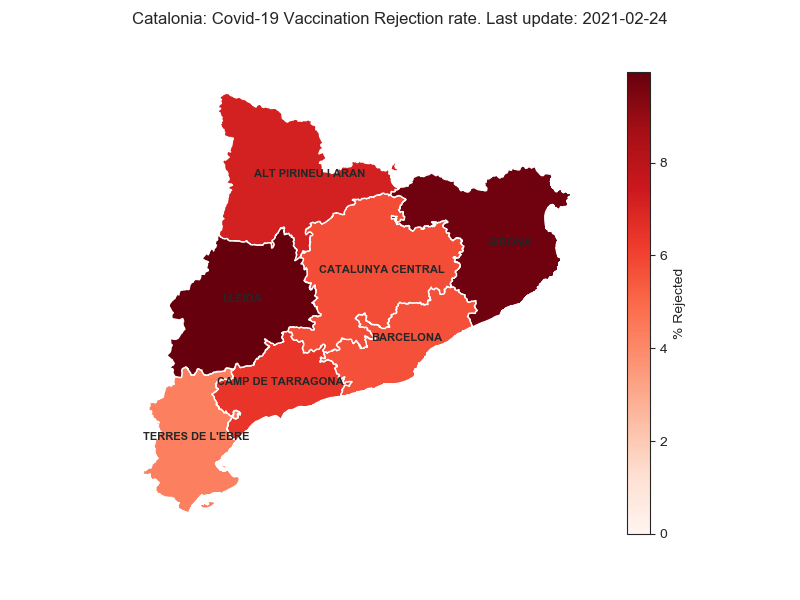

In [1093]:
fig, ax = plt.subplots(figsize = (8,6))
fig.suptitle("Catalonia: Covid-19 Vaccination Rejection rate. Last update: " + last_update)
ax.axis("off")
dfmap.plot(ax=ax,column='rejection_rate',  legend=True,cmap='Reds',  
           legend_kwds={'label': '% Rejected'},vmin=0)


dfmap['coords'] = dfmap['geometry'].apply(lambda x: x.representative_point().coords[:])
dfmap['coords'] = [coords[0] for coords in dfmap['coords']]

for idx, row in dfmap.iterrows():
    plt.annotate(s=row['NOMRS'], xy=row['coords'],
                 horizontalalignment='center', fontsize = 8,fontweight='bold')

plt.savefig('MapCurrentRegionRejectionCat.png')

In [1094]:
fab = pd.DataFrame(casesdf.groupby(["FABRICANT"])["VACUNAT"].count())
fab["percentage"] = 100* fab["VACUNAT"]/sum(fab.VACUNAT)
fab

,VACUNAT,percentage
FABRICANT,,
BioNTech / Pfizer,58433,78.189020
Moderna / Lonza,8801,11.776591
Oxford / AstraZeneca,7499,10.034389


<IPython.core.display.Javascript object>


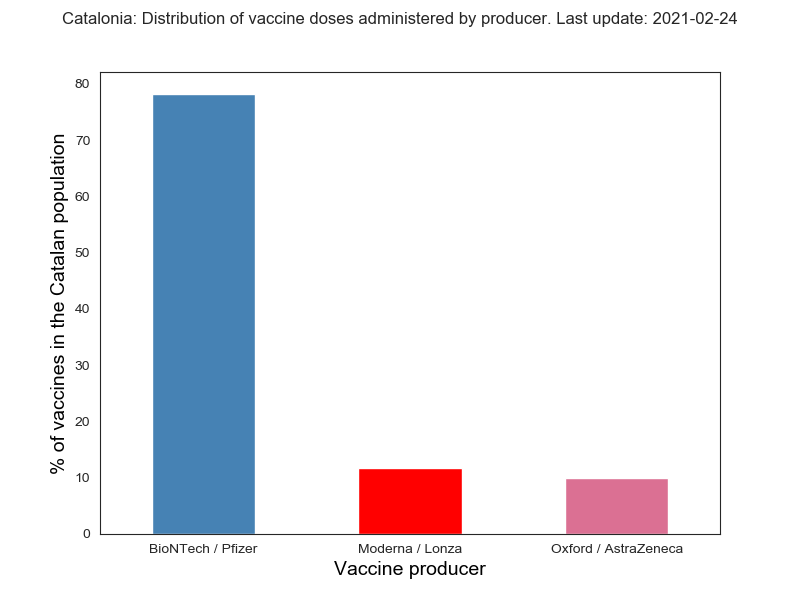

In [1095]:
fig, ax = plt.subplots(figsize = (8,6))
fig.suptitle("Catalonia: Distribution of vaccine doses administered by producer. Last update: " + last_update)

fab.plot.bar(ax=ax, y="percentage", legend=False, color=["steelblue","red","palevioletred"])
ax.tick_params(axis="x",rotation=0)
ax.set_xlabel("Vaccine producer",color="black",fontsize=14)
ax.set_ylabel("% of vaccines in the Catalan population",color="black",fontsize=14)
plt.savefig('VaccineProducer.png')

In [1096]:
print("Data updated?", toget)


Data updated? True
